***Repurposed for NYU Business Analytics Club Spring '24 Technical Workshop run and created by Shrey Khater

# NYPD Crime Reports Dataset

We will be analyzing a dataset comprised of felony, misdemeanor, and other complaints logged to the NYPD from 2006 to 2022.

The dataset is available at:
https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i

It is a big dataset with ~8 million crimes reported to NYPD.

## Attribute Description

Below you can find the description of the attributes, and their datatypes.

| Column | Description | Data Type
|--------|-------------------|----|
| CMPLNT_NUM | Randomly generated persistent ID for each complaint  | bigint(20) |
| CMPLNT_FR | Exact datetime of occurrence for the reported event (or starting date of occurrence, if CMPLNT_TO_DT exists) | datetime |
| CMPLNT_TO | Ending datetime of occurrence for the reported event, if exact time of occurrence is unknown | datetime
| RPT_DT | Date event was reported to police  | date
| KY_CD | Three digit offense classification code | char(3)
| PD_CD | Three digit internal classification code (more granular than Key Code) | char(3)
| JURISDICTION_CODE	| | smallint(6)
| CRM_ATPT_CPTD_CD | Indicator of whether crime was successfully completed or attempted, but failed or was interrupted prematurely | enum('COMPLETED','ATTEMPTED')
| LAW_CAT_CD | Level of offense: felony, misdemeanor, violation  | enum('FELONY','MISDEMEANOR','VIOLATION')
| BORO_NM | The name of the borough in which the incident occurred | enum('BRONX','BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND')
| ADDR_PCT_CD | The precinct in which the incident occurred | char(3)
| LOC_OF_OCCUR_DESC | Specific location of occurrence in or around the premises; inside, opposite of, front of, rear of | enum('FRONT OF','INSIDE','OPPOSITE OF','OUTSIDE','REAR OF')
| PATROL_BORO | |	enum('PATROL BORO BRONX','PATROL BORO BKLYN SOUTH','PATROL BORO BKLYN NORTH','PATROL BORO MAN SOUTH','PATROL BORO MAN NORTH','PATROL BORO QUEENS NORTH','PATROL BORO QUEENS SOUTH','PATROL BORO STATEN ISLAND')
| PREM_TYP_DESC | Specific description of premises; grocery store, residence, street, etc. | varchar(80)
| SUSP_RACE  | |		enum('UNKNOWN','BLACK','WHITE','WHITE HISPANIC','ASIAN / PACIFIC ISLANDER','BLACK HISPANIC','AMERICAN INDIAN/ALASKAN NATIVE')
| VIC_RACE  | |		enum('UNKNOWN','BLACK','WHITE','WHITE HISPANIC','ASIAN / PACIFIC ISLANDER','BLACK HISPANIC','AMERICAN INDIAN/ALASKAN NATIVE')
| SUSP_AGE_GROUP  | |		enum('<18','18-24','25-44','45-64','65+')
| VIC_AGE_GROUP  | |		enum('<18','18-24','25-44','45-64','65+')
| SUSP_SEX  | |		enum('M','F')
| VIC_SEX  | |	enum('M','F','E','D')
| Latitude | Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)  | double
| Longitude | Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326) | double


### Auxiliary Tables

We also have three auxiliary tables `jurisdiction_codes`, `offense_codes`, `penal_codes`, which provide descriptions for the `JURISDICTION_CODE`, `KY_CD`, and `PD_CD` attributes of the main table.




Additional Notes: https://www1.nyc.gov/assets/nypd/downloads/pdf/analysis_and_planning/incident_level_data_footnotes.pdf



## MySQL Database

For ease of access, the entire dataset is sourced in a mysql server with connection details below.

In [ ]:
!sudo pip3 install  -U -q geopandas PyMySQL sqlalchemy sql_magic

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text
import geopandas as gpd
import seaborn as sns
import matplotlib as plt

In [ ]:
conn_string = 'mysql+pymysql://{user}:{password}@{host}:{port}/{db}?charset={encoding}'.format(
    user='student',
    password='dwdstudent2015',
    host = 'db.ipeirotis.org',
    port=3306,
    db='nypd',
    encoding = 'utf8'
)
engine = create_engine(conn_string)

# Data analysis

Follow along and perform your own analysis if you'd like! Feel free to ask question or suggest directions to go in.

## Section one: preliminary analysis


In [ ]:
# Total crimes in dataset (we will be using pandas so as not to make an unnecessary amount of calls to the mysql server; the dataframe created can then be used for a variety of tasks)

sql = 'SELECT CMPLNT_NUM FROM nypd'
with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

len(df)

8324108

In [ ]:
# The number of felonies, misdemeanors, and violations.

sql = '''
SELECT LAW_CAT_CD FROM nypd
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

counts = df['LAW_CAT_CD'].value_counts()

print(counts)

MISDEMEANOR    4625621
FELONY         2596201
VIOLATION      1116853
Name: LAW_CAT_CD, dtype: int64


<Axes: >

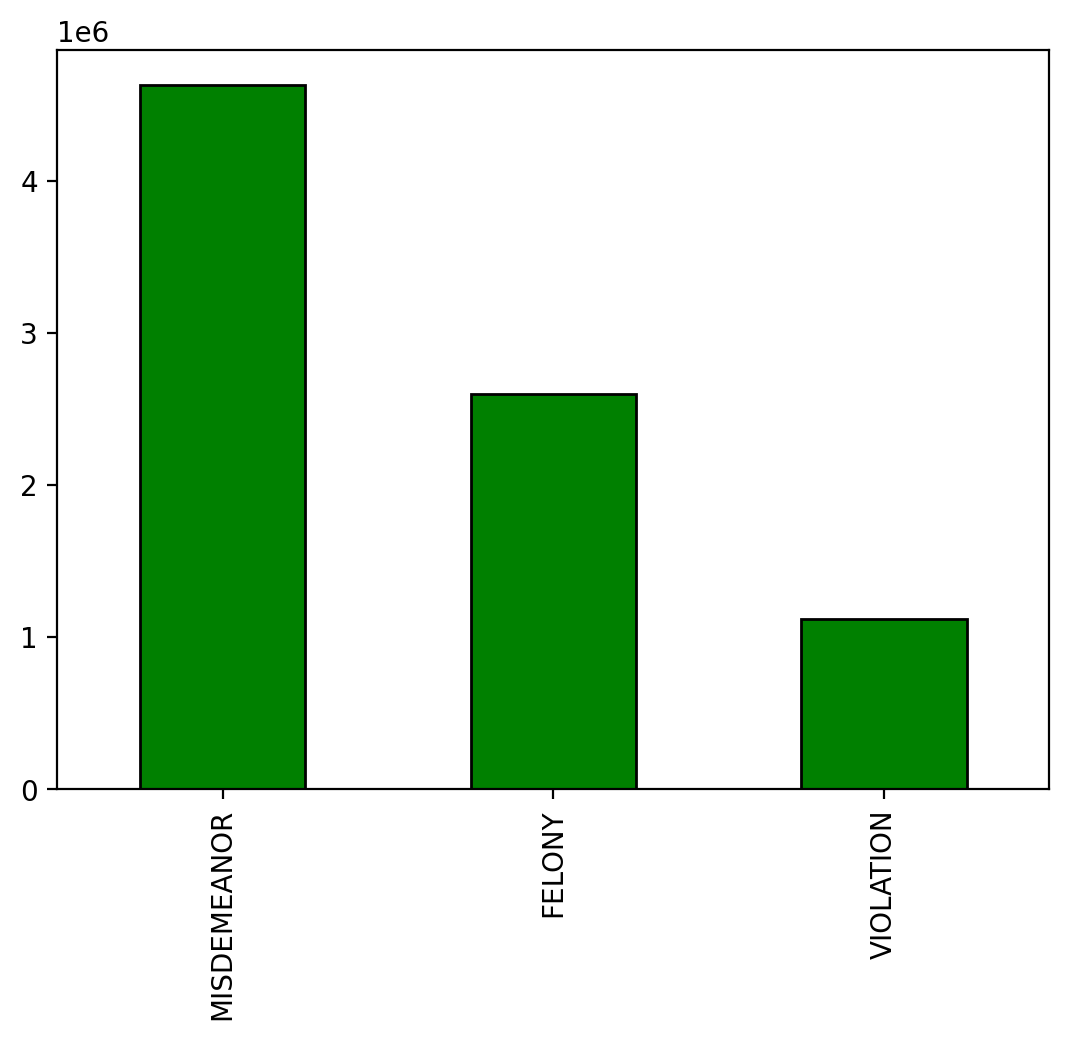

In [ ]:
# Create a bar plot showing the values across the three crime types.
counts.plot(kind='bar', color='green', edgecolor='black')

In [ ]:
# Report number of crimes broken down by felony description (a kind of data filter)
# We are using a join command in SQL!
sql = '''
SELECT nypd.KY_CD, offense_codes.OFNS_DESC, COUNT(*) AS num_incidents
FROM nypd
JOIN offense_codes ON offense_codes.KY_CD = nypd.KY_CD
WHERE LAW_CAT_CD = 'FELONY'
GROUP BY KY_CD
ORDER BY num_incidents DESC
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,KY_CD,OFNS_DESC,num_incidents
0,109,GRAND LARCENY,729798
1,106,FELONY ASSAULT,334184
2,105,ROBBERY,297097
3,107,BURGLARY,282233
4,126,MISCELLANEOUS PENAL LAW,203660
5,110,GRAND LARCENY OF MOTOR VEHICLE,157669
6,121,CRIMINAL MISCHIEF & RELATED OF,151447
7,117,DANGEROUS DRUGS,92795
8,112,THEFT-FRAUD,83698
9,113,FORGERY,82728


<Axes: xlabel='OFNS_DESC'>

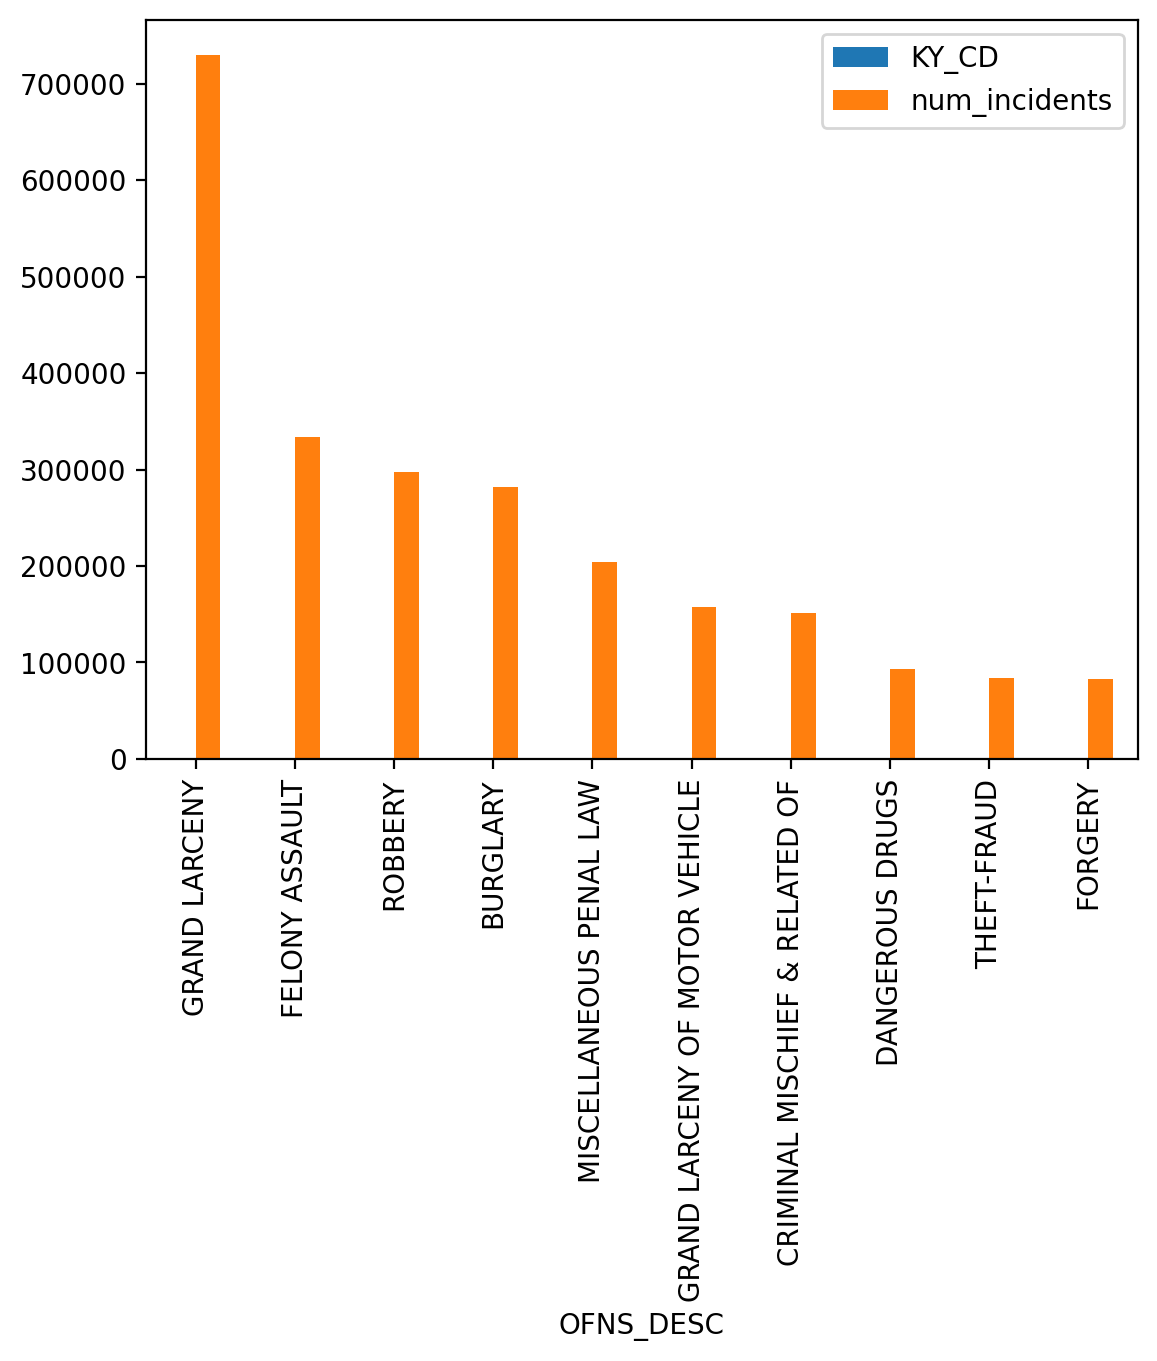

In [ ]:
df.head(10).plot(x='OFNS_DESC', kind='bar')

## Section 2: Is crime increasing or decreasing in NYC?


In [ ]:
# Creates a plot that shows the total number of all reported crimes per year.
sql = '''
SELECT YEAR(CMPLNT_FR) as year, COUNT(*) as num_incidents
FROM nypd
WHERE CMPLNT_FR >= '2006-01-01' AND CMPLNT_FR <= '2022-12-31'
GROUP BY year
ORDER BY year
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,year,num_incidents
0,2006,528805
1,2007,535152
2,2008,528603
3,2009,510872
4,2010,510028
5,2011,498557
6,2012,504699
7,2013,495129
8,2014,491186
9,2015,477801


<Axes: xlabel='year'>

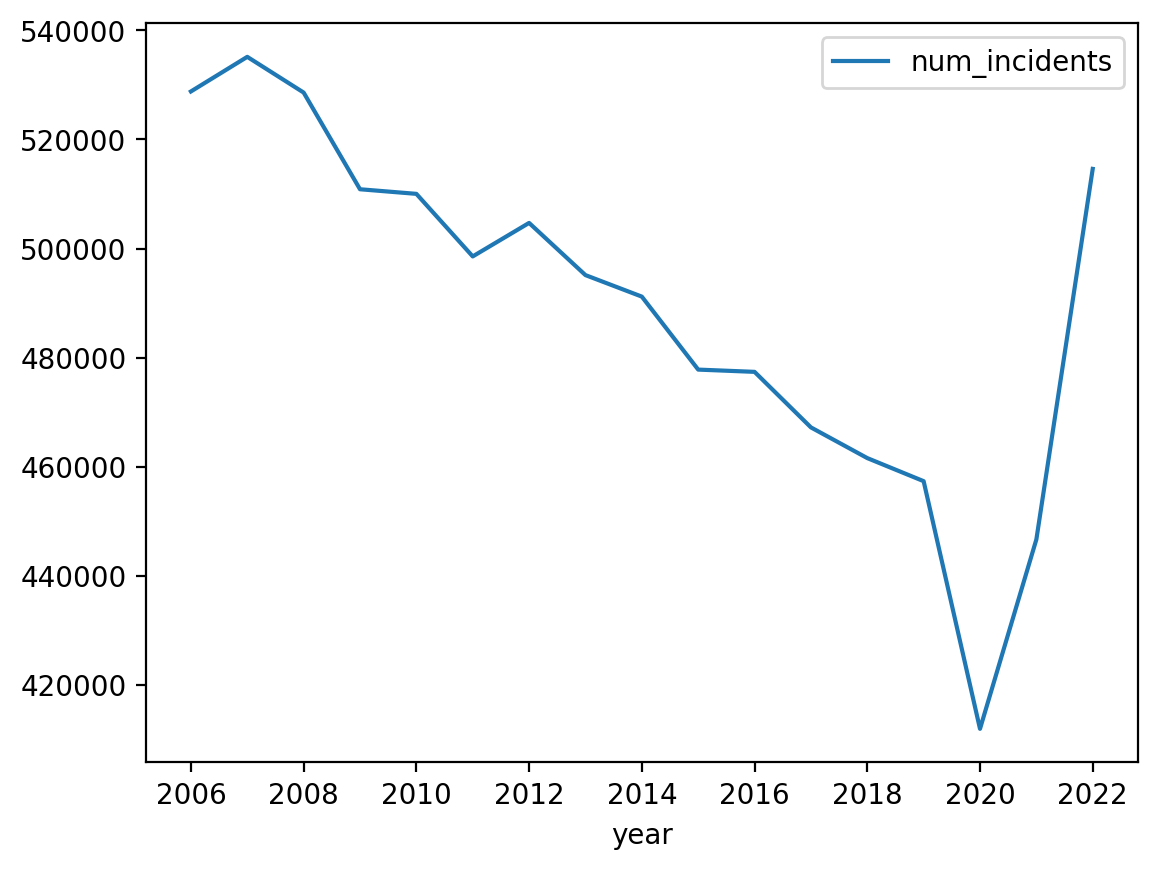

In [ ]:
# Creates a plot that shows the total number of all reported crimes per year.

df.plot(x='year', y='num_incidents')

In [ ]:
# Creates a plot that shows the total number of all reported crimes per month (ie Jan-2006, Feb-2006, ... Jan-2007, Feb-2007, Dec-2022).
# A good example of how to use string processing in a dataset to extract specific information

sql = '''
SELECT DATE_FORMAT(CMPLNT_FR, '%Y-%m-01') as month, COUNT(*) as num_incidents
FROM nypd
WHERE CMPLNT_FR >= '2006-01-01' AND CMPLNT_FR <= '2022-12-31'
GROUP BY month
ORDER BY month
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df



,month,num_incidents
0,2006-01-01,43970
1,2006-02-01,36941
2,2006-03-01,43677
3,2006-04-01,42181
4,2006-05-01,45350
...,...,...
199,2022-08-01,46050
200,2022-09-01,44407
201,2022-10-01,45330
202,2022-11-01,42759


<Axes: xlabel='month'>

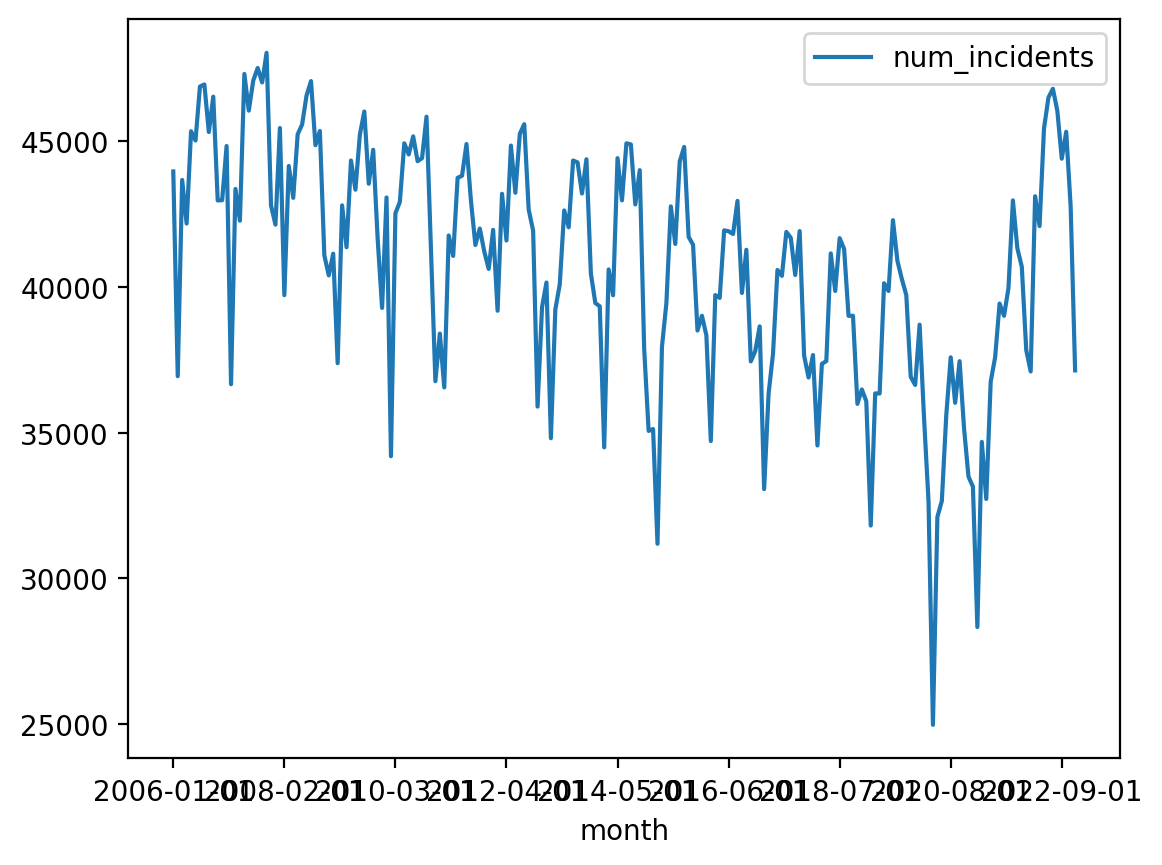

In [ ]:
# Creates a plot that shows the total number of all reported crimes per month (ie Jan-2006, Feb-2006, ... Jan-2007, Feb-2007, Dec-2022).

df.plot(x='month', y='num_incidents')

## Section 3: Analysis of "Big-7" felonies

The NYPD calls the following types of felonies as the "big-7" crimes, as they tend to affect most the quality of life:

* GRAND LARCENY
* ROBBERY
* FELONY ASSAULT
* BURGLARY
* GRAND LARCENY OF MOTOR VEHICLE
* RAPE
* MURDER & NON-NEGL. MANSLAUGHTER


**Hint 1**: The type of felony is included in the `OFNS_DESC` column of the `offense_codes` table and the key for the offense is the `KY_CD` attribute in the main table. You can use the `IN` command in SQL to limit your results to these offenses, or use an `OR` clause. Alternatively, you can use the [`.isin()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.isin.html) command in Pandas.



In [ ]:
sql = '''
SELECT DATE_FORMAT(nypd.CMPLNT_FR, '%Y-%m-01') as month, offense_codes.OFNS_DESC, COUNT(*) as num_incidents
FROM nypd
JOIN offense_codes ON nypd.KY_CD = offense_codes.KY_CD
WHERE CMPLNT_FR >= '2006-01-01' AND CMPLNT_FR <= '2022-12-31'
AND OFNS_DESC IN ('GRAND LARCENY', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY', 'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE', 'MURDER & NON-NEGL. MANSLAUGHTER')
GROUP BY
    month, OFNS_DESC
ORDER BY
    month, OFNS_DESC
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,month,OFNS_DESC,num_incidents
0,2006-01-01,BURGLARY,1945
1,2006-01-01,FELONY ASSAULT,1247
2,2006-01-01,GRAND LARCENY,3744
3,2006-01-01,GRAND LARCENY OF MOTOR VEHICLE,1294
4,2006-01-01,RAPE,195
...,...,...,...
1219,2022-12-01,FELONY ASSAULT,1863
1220,2022-12-01,GRAND LARCENY,3210
1221,2022-12-01,GRAND LARCENY OF MOTOR VEHICLE,1203
1222,2022-12-01,RAPE,60


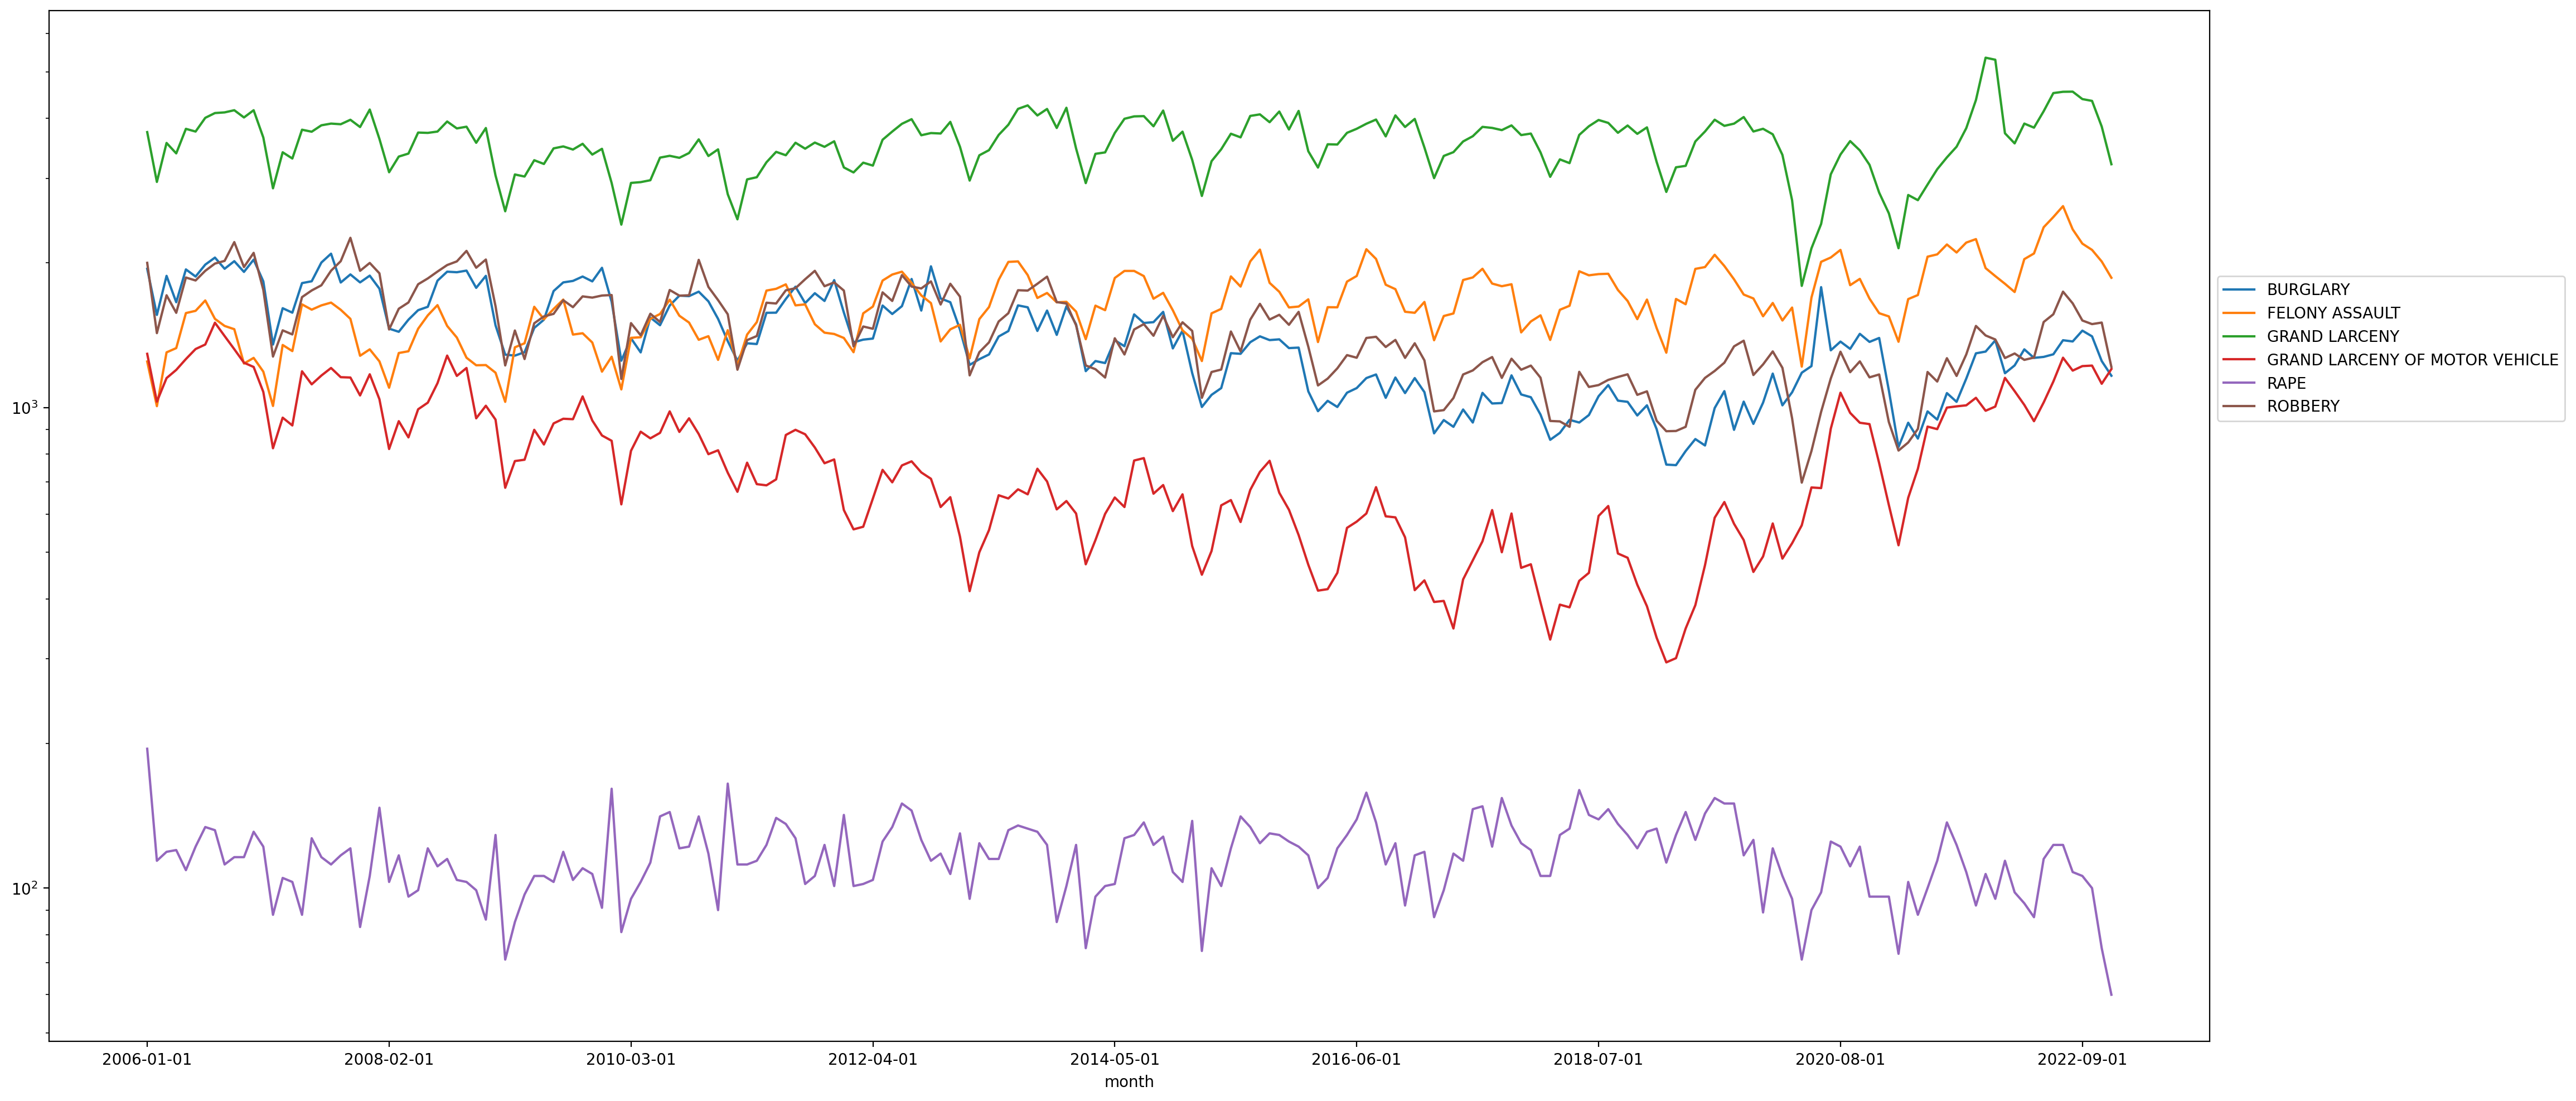

In [ ]:
df_new = df.pivot(index='month', columns='OFNS_DESC', values='num_incidents')
df_new.plot(figsize=(25, 12), logy=True).legend(bbox_to_anchor=(1, 0.75))

## Section 4: Analyzing the Big-7 felonies based on hour of the day.



**Hint 1**: You can use the commands `HOUR()`  in SQL, to extract the hour. (SQL has lots of cool inbuilt commands like this)

**Hint 2**: When creating plots, you may prefer to put the plot for each columns of the dataframe in a separate plot. The option `subplots=True` for the `df.plot()` command provides that capability. (See [the related documentation](https://pandas.pydata.org/pandas-docs/stable/visualization.html#subplots).) If you use the `subplots=True`, you can also use the `layout=(num_rows, num_columns)` option to specify the number of rows (`num_rows`) and the number of columns (`num_columns`) to use for the grid arrangement.


In [ ]:
sql = '''
SELECT HOUR(nypd.CMPLNT_FR) as hour, offense_codes.OFNS_DESC, COUNT(*) as num_incidents
FROM nypd
JOIN offense_codes ON nypd.KY_CD = offense_codes.KY_CD
WHERE CMPLNT_FR >= '2006-01-01' AND CMPLNT_FR <= '2022-12-31'
		AND OFNS_DESC IN ('GRAND LARCENY', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY', 'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE', 'MURDER & NON-NEGL. MANSLAUGHTER')
GROUP BY
    hour, OFNS_DESC
ORDER BY
    hour, OFNS_DESC
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,hour,OFNS_DESC,num_incidents
0,0,BURGLARY,9581
1,0,FELONY ASSAULT,18449
2,0,GRAND LARCENY,40967
3,0,GRAND LARCENY OF MOTOR VEHICLE,6930
4,0,MURDER & NON-NEGL. MANSLAUGHTER,429
...,...,...,...
163,23,GRAND LARCENY,23080
164,23,GRAND LARCENY OF MOTOR VEHICLE,11160
165,23,MURDER & NON-NEGL. MANSLAUGHTER,427
166,23,RAPE,1366


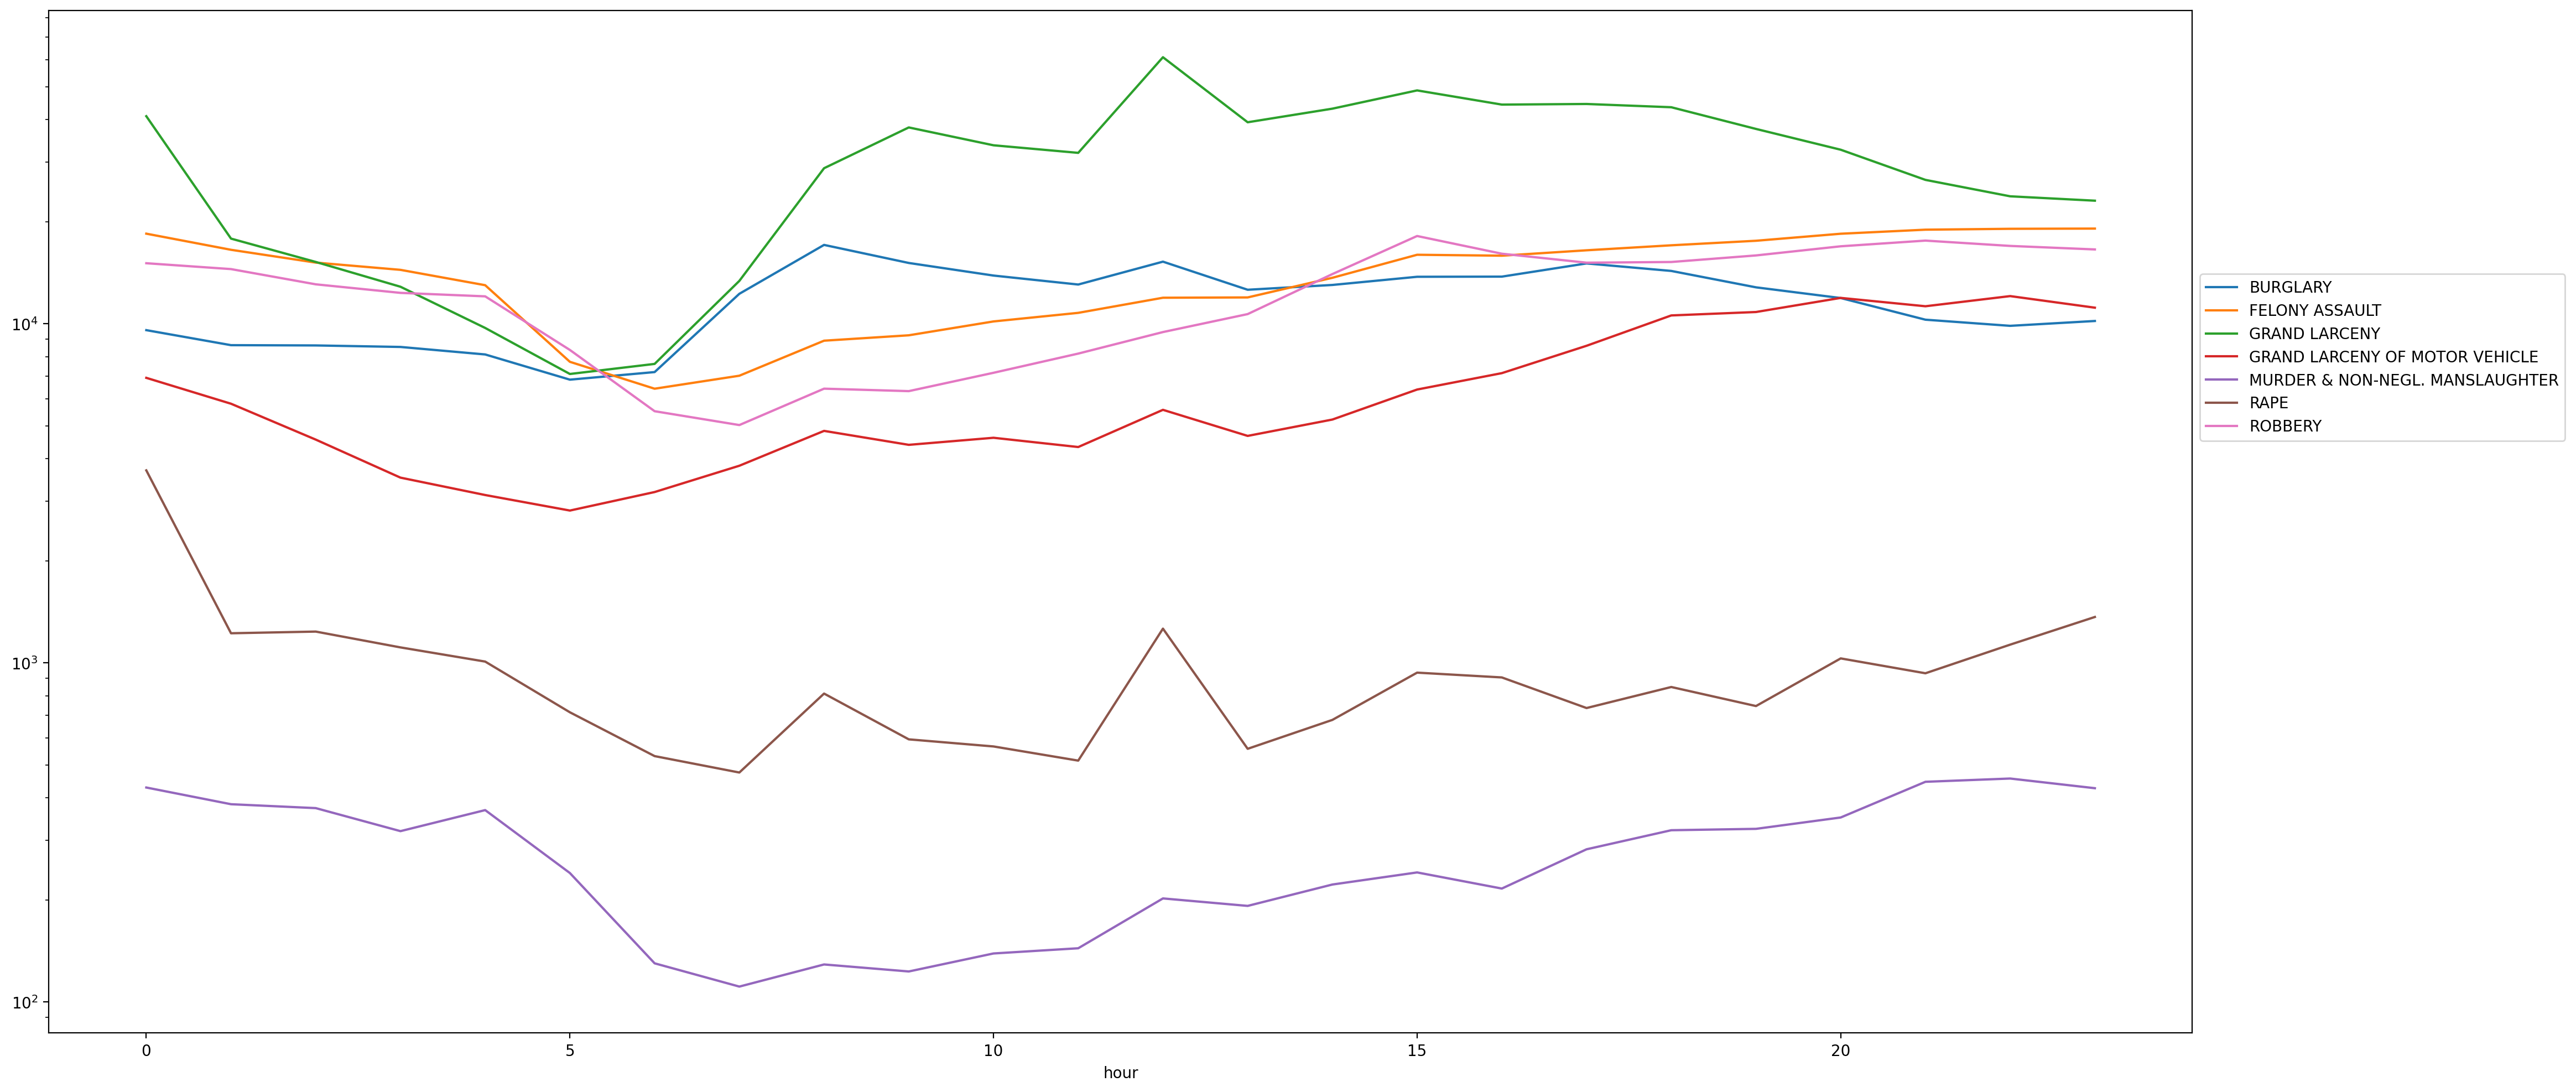

In [ ]:
# Creating a plot showing the number of big-7 felonies, broken down by hour of day.
 # (e.g., 8375 reported robberies at 5am). Note the log scale used in the plot.

df_new = df.pivot(index='hour', columns='OFNS_DESC', values='num_incidents')
df_new.plot(figsize=(25, 12), logy=True).legend(bbox_to_anchor=(1, 0.75))

array([[<Axes: title={'center': 'BURGLARY'}, xlabel='hour'>,
        <Axes: title={'center': 'FELONY ASSAULT'}, xlabel='hour'>],
       [<Axes: title={'center': 'GRAND LARCENY'}, xlabel='hour'>,
        <Axes: title={'center': 'GRAND LARCENY OF MOTOR VEHICLE'}, xlabel='hour'>],
       [<Axes: title={'center': 'MURDER & NON-NEGL. MANSLAUGHTER'}, xlabel='hour'>,
        <Axes: title={'center': 'RAPE'}, xlabel='hour'>],
       [<Axes: title={'center': 'ROBBERY'}, xlabel='hour'>,
        <Axes: xlabel='hour'>]], dtype=object)

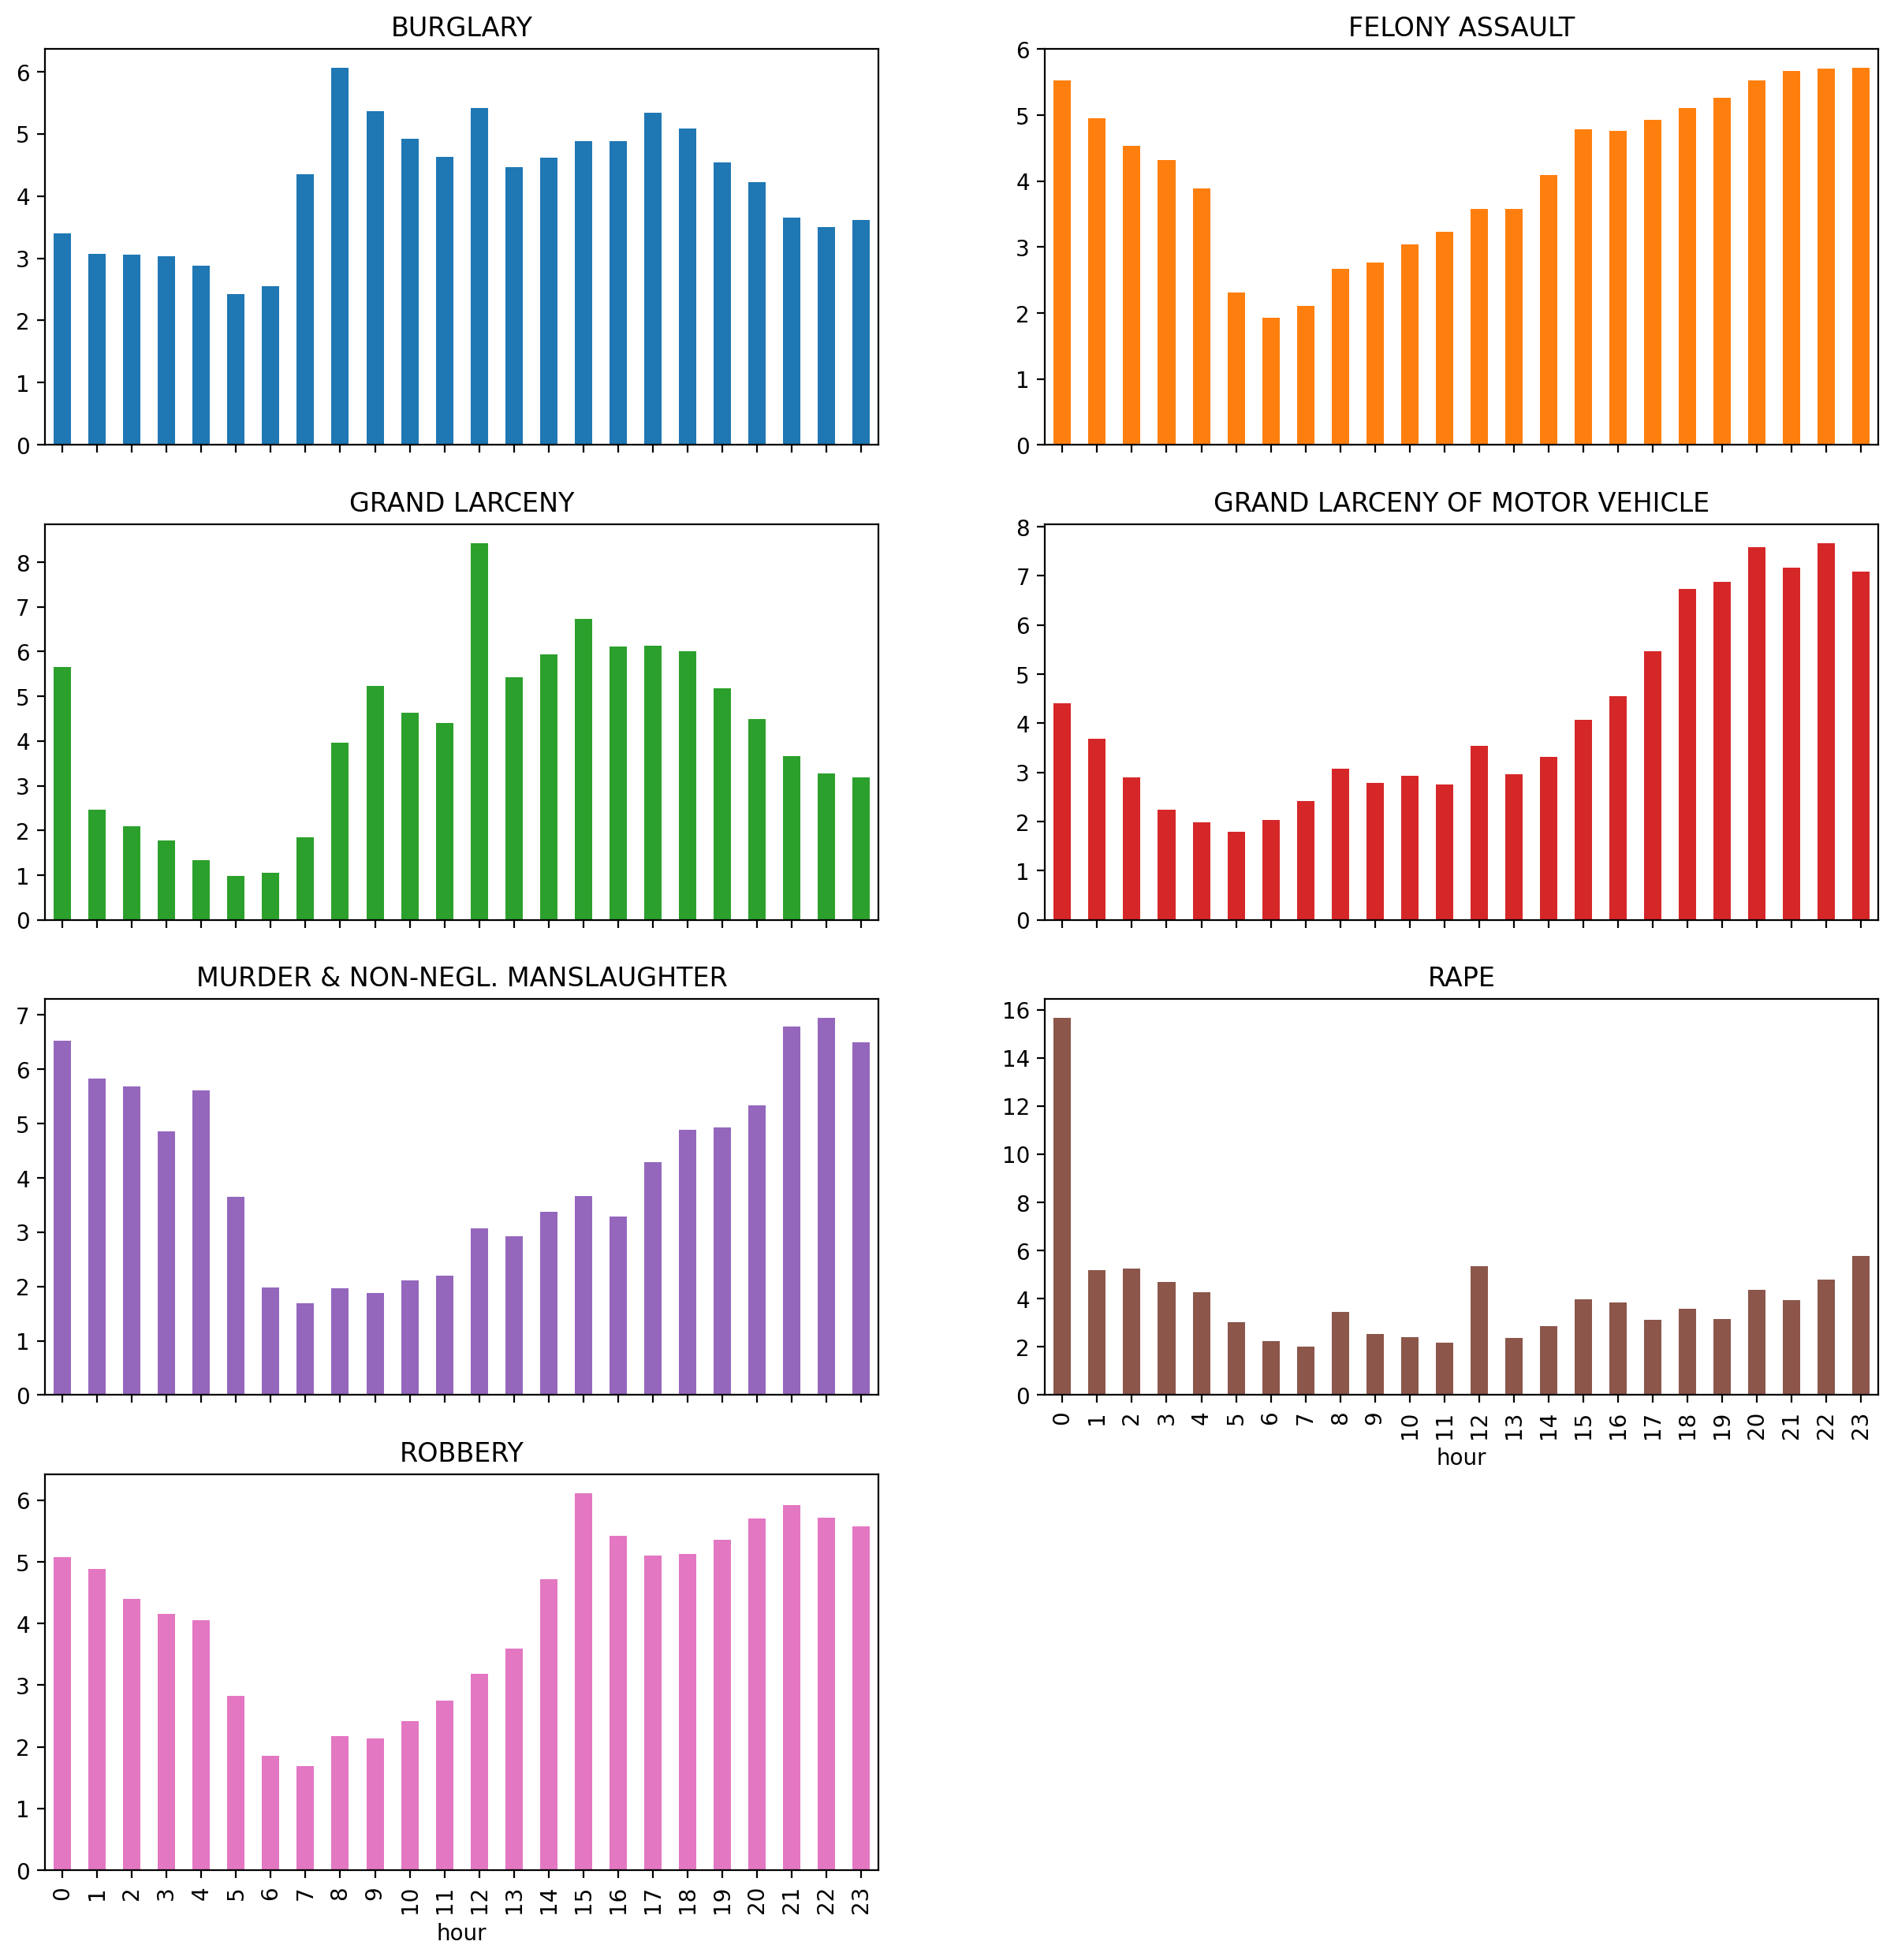

In [ ]:
# Showing the number of big-7 felonies, broken down by hour of day.
# To allow for easier comparison among felonies, normalize the data by dividing
# by the total incidents for each type of felony. (e.g., 2.8% of the reported
# robberies happen at 5am). Generate a bar plot with the results.

df_4 = df.pivot(index='hour', columns='OFNS_DESC', values='num_incidents').fillna(0)

df_4b = df_4.div(df_4.sum(axis=0), axis=1) * 100

df_4b.plot(kind='bar', subplots=True, layout=(4, 2), figsize=(15, 15), sharex=True, legend=False)

## Section 5: Advanced visualizations (Spatial Analysis)


In [ ]:
# Dataset from NYC Open Data: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq
!curl 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON' -o nyc-neighborhoods.geojson

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4370k    0 4370k    0     0  5138k      0 --:--:-- --:--:-- --:--:-- 5135k


<Axes: >

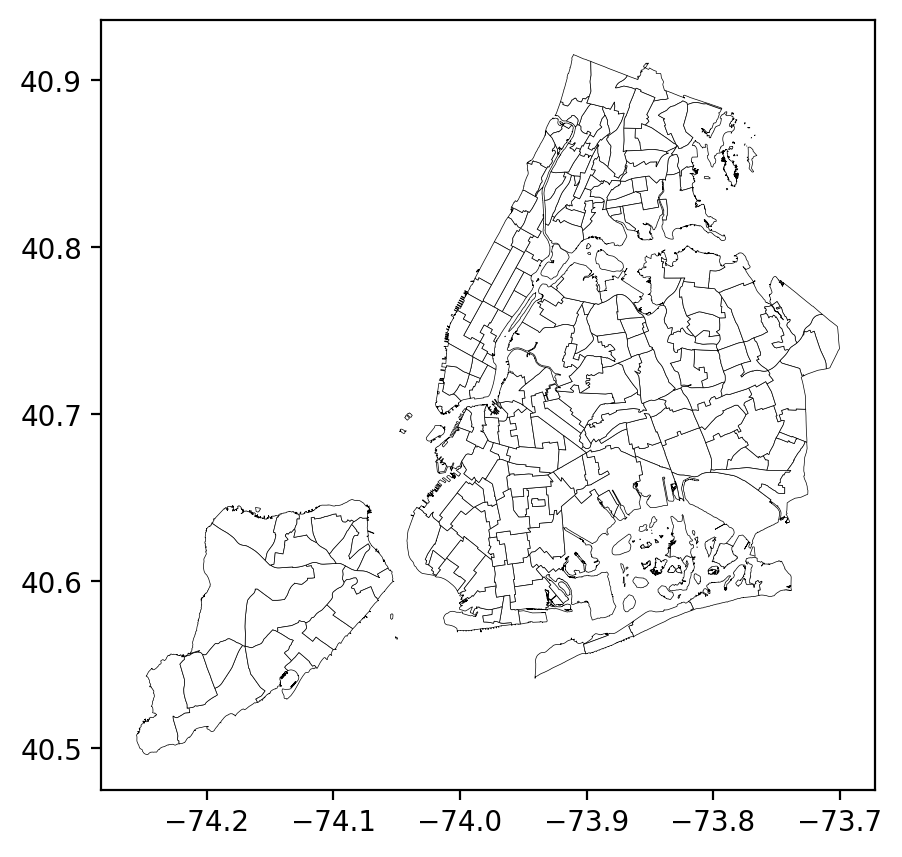

In [ ]:
# Load the shapefile
df_nyc = gpd.GeoDataFrame.from_file('nyc-neighborhoods.geojson')

# Create a plot
df_nyc.plot(linewidth=0.25, color='White', edgecolor='Black', figsize=(5, 5))

In [ ]:
sql = '''
SELECT Latitude, Longitude, OFNS_DESC
FROM nypd
JOIN offense_codes ON nypd.KY_CD = offense_codes.KY_CD
WHERE YEAR(CMPLNT_FR) = 2022 AND Latitude IS NOT NULL AND Longitude IS NOT NULL
AND OFNS_DESC IN ('GRAND LARCENY', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY', 'GRAND LARCENY OF MOTOR VEHICLE')
'''


with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,Latitude,Longitude,OFNS_DESC
0,40.749405,-73.991783,FELONY ASSAULT
1,40.697994,-73.797859,FELONY ASSAULT
2,40.701313,-73.981796,FELONY ASSAULT
3,40.701790,-73.808403,FELONY ASSAULT
4,40.744446,-73.773697,FELONY ASSAULT
...,...,...,...
119855,40.762264,-73.958565,GRAND LARCENY
119856,40.848667,-73.937370,GRAND LARCENY
119857,40.805737,-73.940643,ROBBERY
119858,40.683292,-73.974854,GRAND LARCENY


In [ ]:
#YOUR CODE HERE

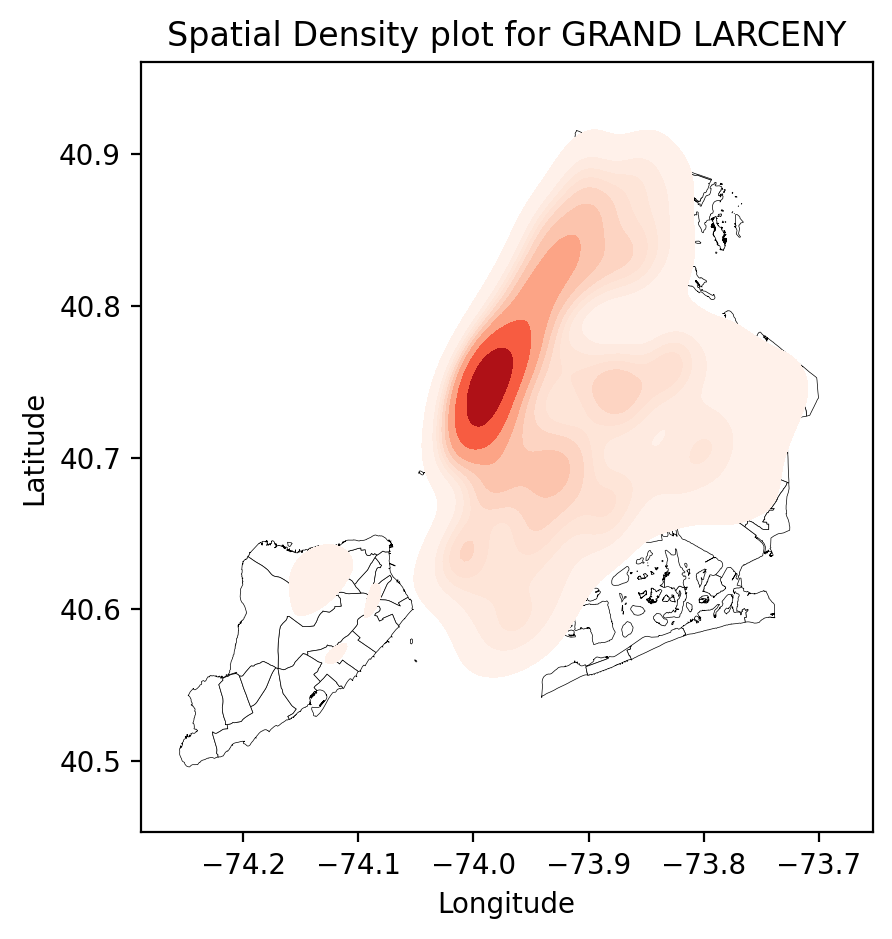

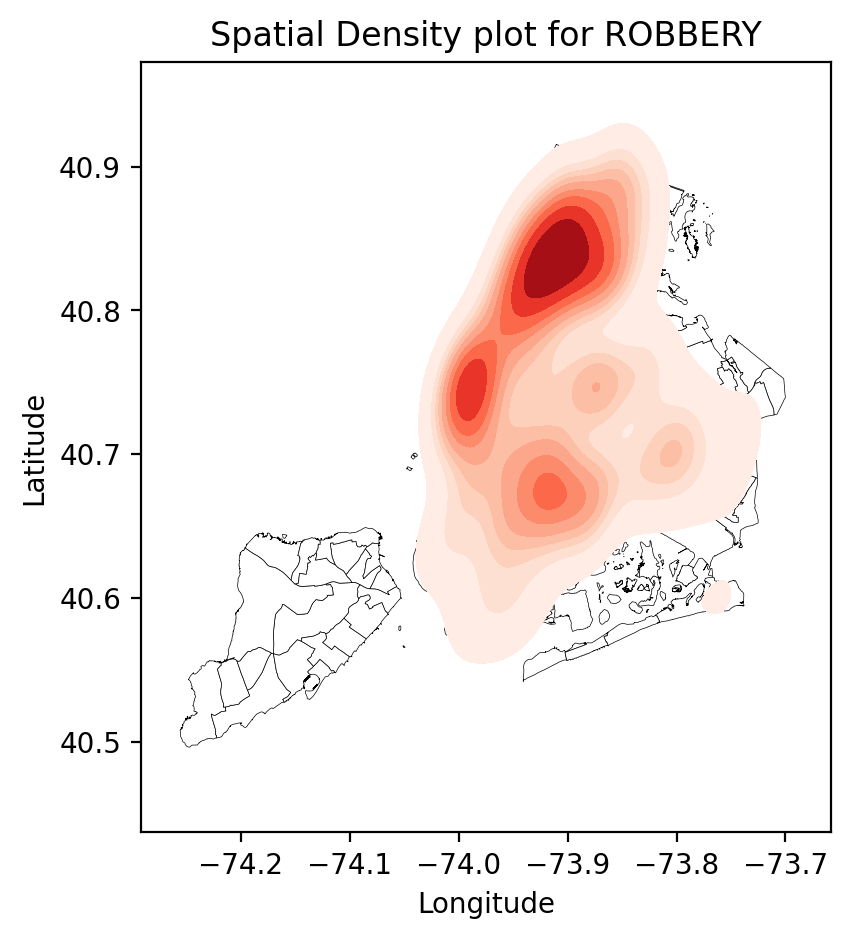

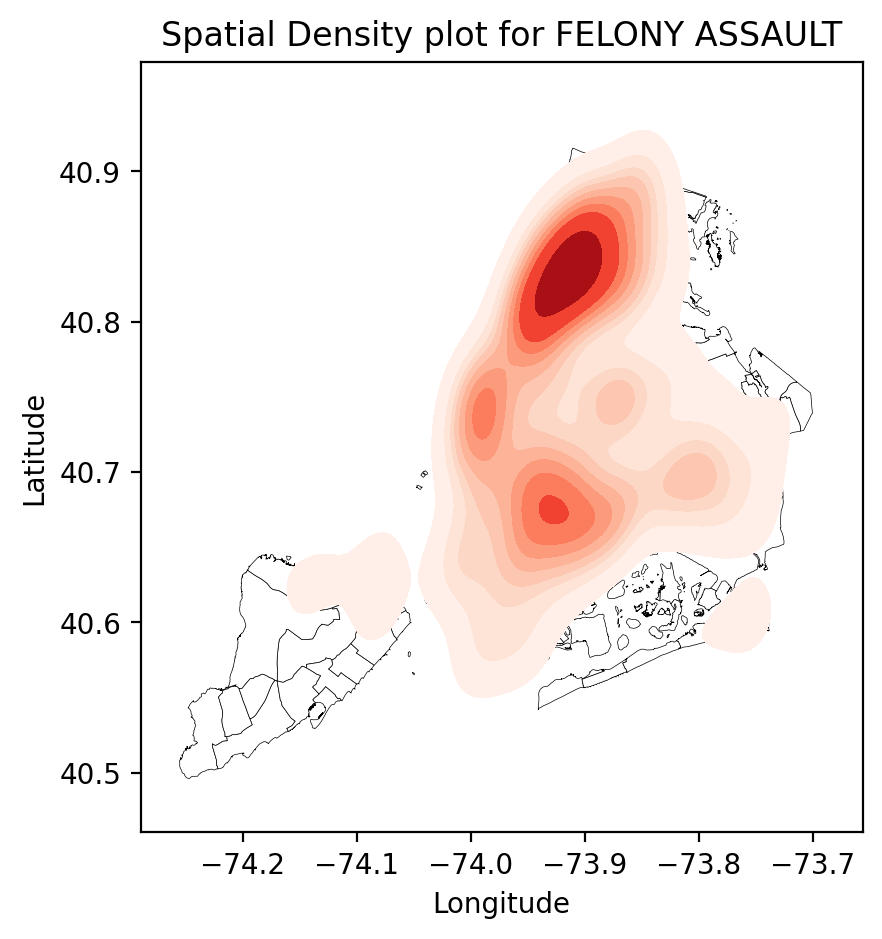

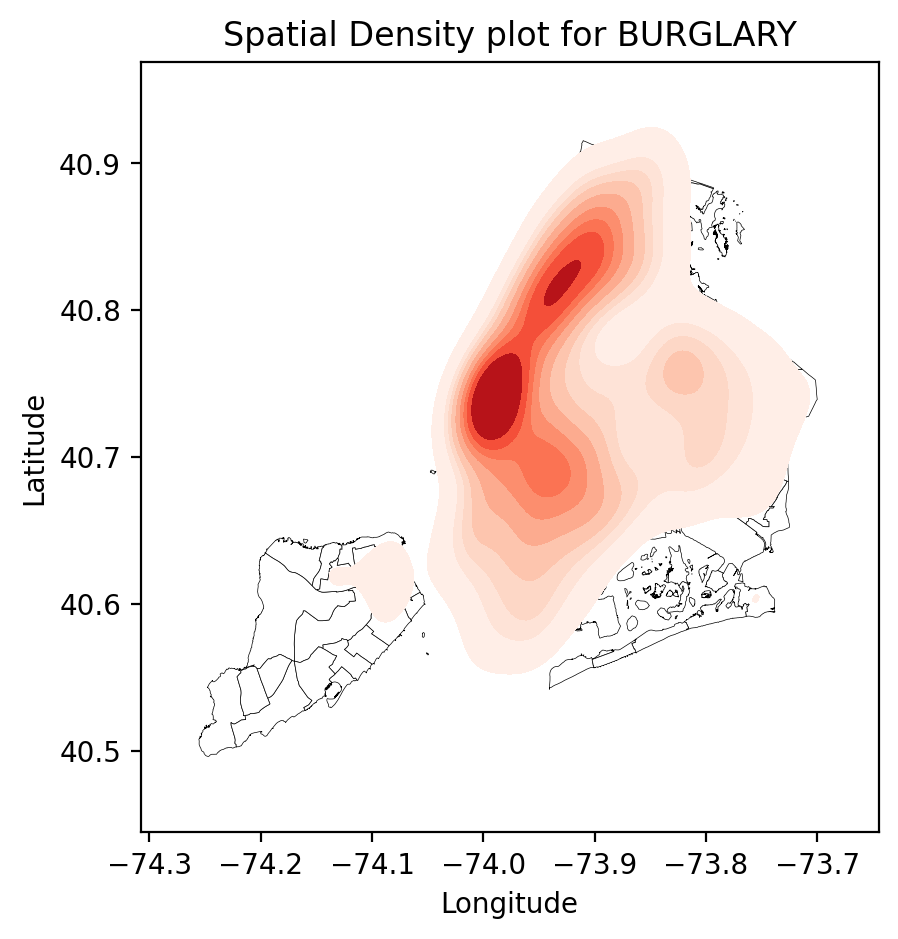

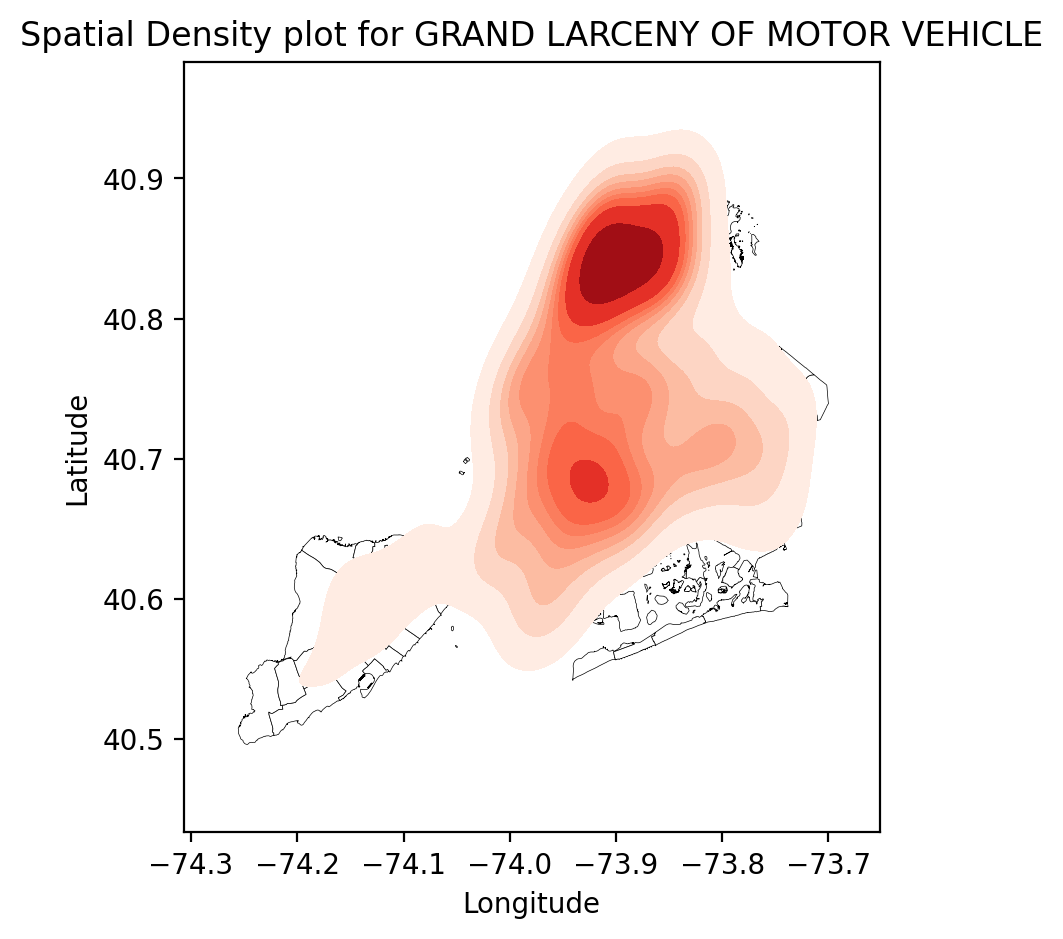

In [ ]:
import matplotlib.pyplot as plt

for felony in ['GRAND LARCENY', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY', 'GRAND LARCENY OF MOTOR VEHICLE']:
    df_felony = df[df['OFNS_DESC'] == felony].sample(frac=0.2)

    df_nyc.plot(linewidth=0.25, color='White', edgecolor='Black', figsize=(5, 5))
    sns.kdeplot(data=df_felony, x='Longitude', y='Latitude', cmap="Reds", fill=True)

    plt.title("Spatial Density plot for " + felony)
    plt.show()

